In [356]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import random
import time


In [357]:
# STEP 2: Load Data
demand_df = pd.read_csv('demand.csv').drop(columns=['District'], errors='ignore')
supply_df = pd.read_csv('supply.csv', index_col=0)
cost_df = pd.read_csv('cost.csv')

# To display data
display(demand_df.head())
display(supply_df)
display(cost_df)

,Node,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,Node_0,6.95,6.26,5.56,4.87,4.17,5.56,8.34,10.43,11.82,...,11.82,11.12,10.43,9.73,9.04,8.34,7.65,8.34,9.04,9.73
1,Node_1,44.58,40.13,35.67,31.21,26.75,35.67,53.50,66.88,75.79,...,75.79,71.34,66.88,62.42,57.96,53.50,49.04,53.50,57.96,62.42
2,Node_2,19.50,17.55,15.60,13.65,11.70,15.60,23.40,29.25,33.16,...,33.16,31.21,29.25,27.30,25.35,23.40,21.45,23.40,25.35,27.30
3,Node_3,13.52,12.17,10.82,9.47,8.11,10.82,16.23,20.28,22.99,...,22.99,21.64,20.28,18.93,17.58,16.23,14.87,16.23,17.58,18.93
4,Node_4,2.51,2.26,2.01,1.76,1.51,2.01,3.01,3.77,4.27,...,4.27,4.02,3.77,3.52,3.27,3.01,2.76,3.01,3.27,3.52


,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
Source,,,,,,,,,,,,,,,,,,,,,
Hydro,1500,1503.4,1513.4,1529.3,1550,1574.1,1600,1625.9,1650,1670.7,...,1686.6,1670.7,1650,1625.9,1600,1574.1,1550,1529.3,1513.4,1503.4
Solar,0,0.0,0.0,0.0,0,0.0,0,77.6,150,212.1,...,259.8,212.1,150,77.6,0,0.0,0,0.0,0.0,0.0
Wind,15,12.0,9.0,11.0,7,4.0,6,5.0,4,3.0,...,1.0,4.0,3,3.0,5,4.0,7,6.0,9.0,13.0


,Source,Cost (Rs/kWh)
0,Hydro,6
1,Solar,9
2,Wind,12


In [358]:
# Get the total number of missing values in the entire DataFrame
missing_demand = demand_df.isnull().sum().sum()
missing_supply = supply_df.isnull().sum().sum()
missing_cost = cost_df.isnull().sum().sum()

# Print the total number of missing values
print(f"Missing values in demand data: {missing_demand}")
print(f"Missing values in supply data: {missing_supply}")
print(f"Missing values in cost data: {missing_cost}")

Missing values in demand data: 0
Missing values in supply data: 0
Missing values in cost data: 0


In [359]:
# STEP 3: Data Preprocessing
demand = demand_df.drop(columns=['Node'], errors='ignore').values  # shape: (77, 24)
supply = supply_df.values                                          # shape: (3, 24)
cost = cost_df['Cost (Rs/kWh)'].values                             # shape: (3,)

# STEP 4: Parameters
NUM_NODES = demand.shape[0]
NUM_SOURCES = supply.shape[0]
HOURS = demand.shape[1]
POP_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.2


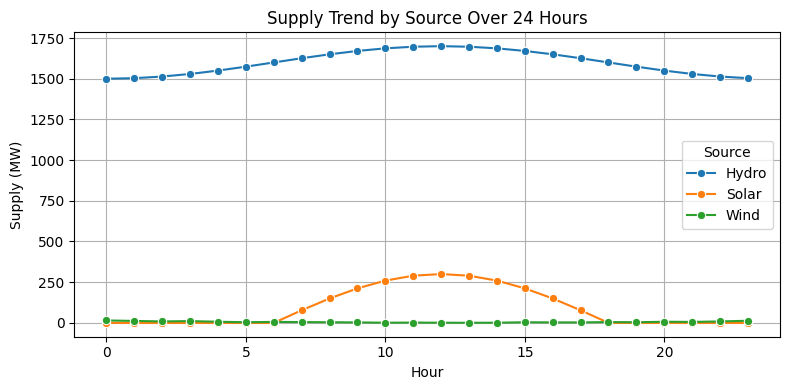

In [360]:
# STEP 5: Visualization - Supply Trend
supply_long = supply_df.reset_index().melt(id_vars='Source', var_name='Hour', value_name='Supply')
supply_long['Hour'] = supply_long['Hour'].str.extract('(\d+)').astype(int)

plt.figure(figsize=(8, 4))
sns.lineplot(data=supply_long, x='Hour', y='Supply', hue='Source', marker='o')
plt.title("Supply Trend by Source Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Supply (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

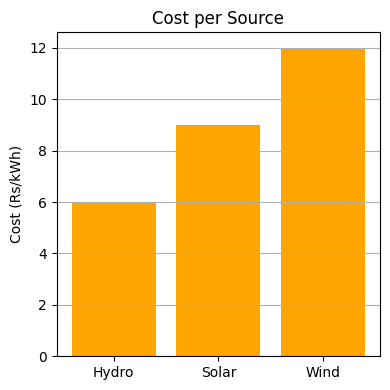

In [361]:
# STEP 6: Cost per Source
plt.figure(figsize=(4, 4))
plt.bar(cost_df['Source'], cost_df['Cost (Rs/kWh)'], color='orange')
plt.title("Cost per Source")
plt.ylabel("Cost (Rs/kWh)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

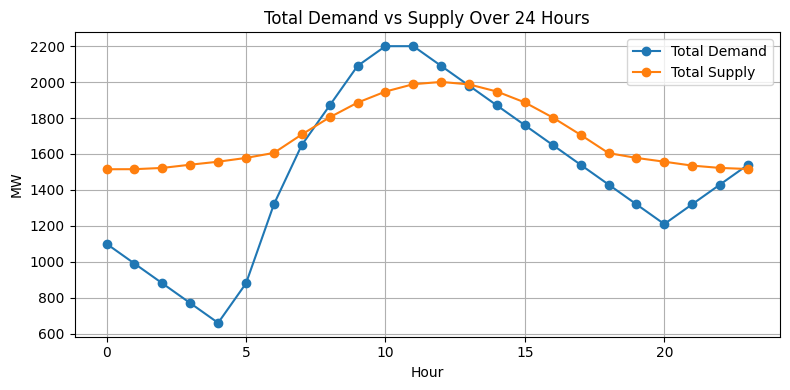

In [362]:
# STEP 7: Total Demand vs Supply
demand_sum = demand_df.drop(columns='Node').sum()
supply_sum = supply_df.sum()

plt.figure(figsize=(8, 4))
plt.plot(range(24), demand_sum.values, label="Total Demand", marker='o')
plt.plot(range(24), supply_sum.values, label="Total Supply", marker='o')
plt.title("Total Demand vs Supply Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [363]:
## STEP 8: Genetic Algorithm Components

def create_chromosome():
    return np.random.dirichlet(np.ones(NUM_SOURCES), size=NUM_NODES)

def fitness(chromosome, demand_hour, supply_hour, cost, loss_matrix):
    allocation_per_node = chromosome @ supply_hour
    mismatch = np.sum((allocation_per_node - demand_hour) ** 2)
    total_cost = np.sum((chromosome.sum(axis=0) * supply_hour) * cost)
    loss_penalty = allocation_per_node.T @ loss_matrix @ allocation_per_node

    alpha, beta, gamma = 1.0, 1.0, 1.0
    fitness_value = - (alpha * mismatch + beta * total_cost + gamma * loss_penalty)
    return fitness_value

def select(pop, scores):
    idx = random.choices(range(len(pop)), k=3)
    best = max(idx, key=lambda i: scores[i])
    return pop[best]

def crossover(p1, p2):
    point = random.randint(1, NUM_NODES - 2)
    return np.vstack((p1[:point], p2[point:]))

def mutate(child):
    idx = random.randint(0, NUM_NODES - 1)
    child[idx] = np.random.dirichlet(np.ones(NUM_SOURCES))
    return child

def repair_chromosome(chromosome, supply_hour):
    allocation = chromosome * supply_hour  # Broadcasting
    total_alloc_per_source = allocation.sum(axis=0)
    over_alloc = total_alloc_per_source > supply_hour

    for source_idx, over in enumerate(over_alloc):
        if over:
            scale_factor = supply_hour[source_idx] / total_alloc_per_source[source_idx]
            allocation[:, source_idx] *= scale_factor

    repaired_chromosome = np.zeros_like(chromosome)
    for source_idx in range(chromosome.shape[1]):
        if supply_hour[source_idx] > 0:
            repaired_chromosome[:, source_idx] = allocation[:, source_idx] / supply_hour[source_idx]
        else:
            repaired_chromosome[:, source_idx] = 0

    return repaired_chromosome

def run_ga(demand_hour, supply_hour, cost, loss_matrix):
    population = [create_chromosome() for _ in range(POP_SIZE)]
    best_scores = []

    for _ in range(GENERATIONS):
        scores = [fitness(ind, demand_hour, supply_hour, cost, loss_matrix) for ind in population]
        best_scores.append(max(scores))

        new_pop = []
        for _ in range(POP_SIZE):
            p1, p2 = select(population, scores), select(population, scores)
            child = crossover(p1, p2)
            if random.random() < MUTATION_RATE:
                child = mutate(child)

            child = repair_chromosome(child, supply_hour)
            new_pop.append(child)

        population = new_pop

    return best_scores

In [364]:
## STEP 9: Run Serial vs Parallel GA for all 24 Hours

def run_all_hours():
    serial_scores = []
    parallel_scores = []

    # Serial Execution
    serial_start = time.time()
    for h in range(HOURS):
        demand_h = demand[:, h]
        supply_h = supply[:, h]
        scores = run_ga(demand_h, supply_h, cost, loss_matrix)
        serial_scores.append(scores)
    serial_time = time.time() - serial_start

    # Parallel Execution
    parallel_start = time.time()
    parallel_outputs = Parallel(n_jobs=-1)(
        delayed(run_ga)(demand[:, h], supply[:, h], cost, loss_matrix) for h in range(HOURS)
    )
    parallel_time = time.time() - parallel_start

    return serial_scores, parallel_outputs, serial_time, parallel_time

# Before running, define loss_matrix and cost properly:
loss_matrix = np.ones((NUM_NODES, NUM_NODES)) * 0.01
np.fill_diagonal(loss_matrix, 0)

serial_results, parallel_results, serial_time, parallel_time = run_all_hours()

print(f"\n Serial Total Time:   {serial_time:.2f} sec")
print(f" Parallel Total Time: {parallel_time:.2f} sec")



 Serial Total Time:   10.59 sec
 Parallel Total Time: 9.72 sec


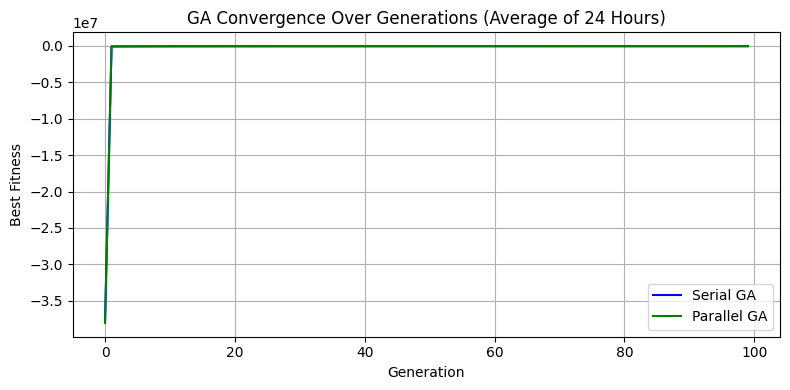

In [365]:
# STEP 10: Convergence Comparison (Average Over Generations)
avg_serial = np.mean(serial_results, axis=0)
avg_parallel = np.mean(parallel_results, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_serial, label="Serial GA", color='blue')
plt.plot(avg_parallel, label="Parallel GA", color='green')
plt.title("GA Convergence Over Generations (Average of 24 Hours)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

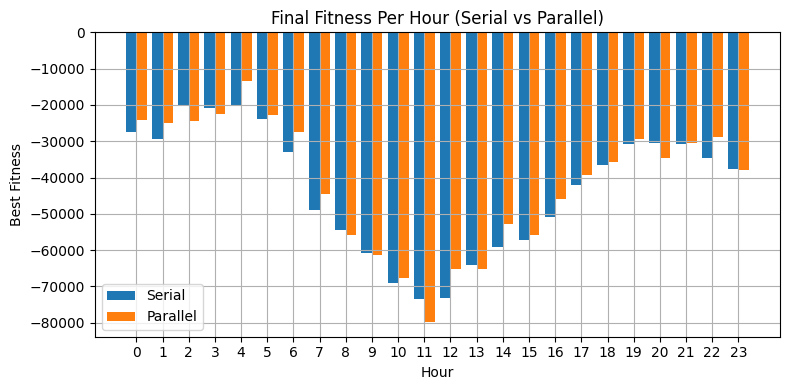

In [366]:
# STEP 11: Final Fitness Per Hour Bar Chart
final_serial = [res[-1] for res in serial_results]
final_parallel = [res[-1] for res in parallel_results]

plt.figure(figsize=(8, 4))
bar_width = 0.4
x = np.arange(HOURS)
plt.bar(x - bar_width/2, final_serial, width=bar_width, label="Serial")
plt.bar(x + bar_width/2, final_parallel, width=bar_width, label="Parallel")
plt.title("Final Fitness Per Hour (Serial vs Parallel)")
plt.xlabel("Hour")
plt.ylabel("Best Fitness")
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

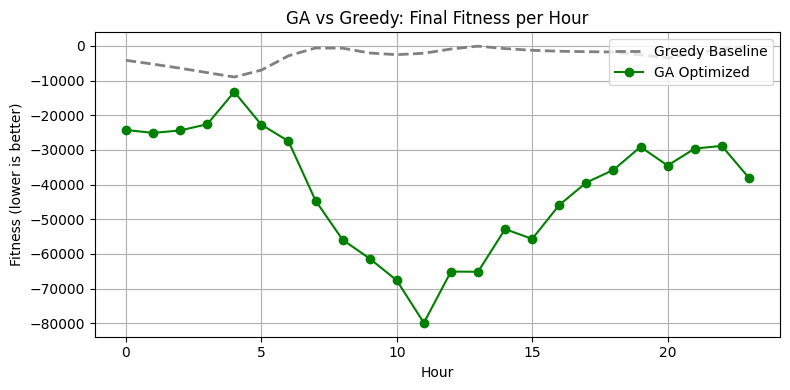

In [367]:
# Step 12: Greedy Baseline Comparison ---
def greedy_baseline(demand_hour, supply_hour):
    return -abs(np.sum(demand_hour) - np.sum(supply_hour)) * 10

greedy_scores = [greedy_baseline(demand[:, h], supply[:, h]) for h in range(HOURS)]
ga_scores = [max(s) for s in parallel_results]

plt.figure(figsize=(8, 4))
plt.plot(range(HOURS), greedy_scores, label="Greedy Baseline", color='gray', linestyle='--', linewidth=2)
plt.plot(range(HOURS), ga_scores, label="GA Optimized", color='green', marker='o')
plt.xlabel("Hour")
plt.ylabel("Fitness (lower is better)")
plt.title("GA vs Greedy: Final Fitness per Hour")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [368]:
# --- Create Summary Table ---
summary = []

for h in range(24):
    total_demand = demand[:, h].sum()
    total_supply = supply[:, h].sum()
    final_fitness = parallel_results[h][-1] if isinstance(parallel_results[h], list) else parallel_results[h]

    summary.append({"Hour": h,
                    "Total Demand (MW)": total_demand,
                    "Total Supply (MW)": total_supply,
                    "Final Fitness": final_fitness })

summary_df = pd.DataFrame(summary)

# Display the table
print(summary_df)


    Hour  Total Demand (MW)  Total Supply (MW)  Final Fitness
0      0            1099.98             1515.0  -24222.341368
1      1             990.01             1515.4  -25087.401635
2      2             880.02             1522.4  -24376.476480
3      3             769.99             1540.3  -22592.325993
4      4             659.97             1557.0  -13278.680333
5      5             880.02             1578.1  -22717.985212
6      6            1319.99             1606.0  -27455.472997
7      7            1649.97             1708.5  -44586.993730
8      8            1869.97             1804.0  -55895.185546
9      9            2090.01             1885.8  -61321.222394
10    10            2200.02             1947.4  -67616.765855
11    11            2200.02             1988.4  -79864.962616
12    12            2090.01             2001.0  -65067.994996
13    13            1979.94             1987.2  -65126.285260
14    14            1869.97             1947.4  -52829.533920
15    15

In [369]:
best_hour = summary_df.loc[summary_df['Final Fitness'].idxmax()]
worst_hour = summary_df.loc[summary_df['Final Fitness'].idxmin()]

def format_series(series):
    return series.apply(lambda x: f"{x:.2f}" if isinstance(x, float) else x)

print("Best Hour:\n", format_series(best_hour).to_string())
print("\nWorst Hour:\n", format_series(worst_hour).to_string())

Best Hour:
 Hour                      4.00
Total Demand (MW)       659.97
Total Supply (MW)      1557.00
Final Fitness        -13278.68

Worst Hour:
 Hour                     11.00
Total Demand (MW)      2200.02
Total Supply (MW)      1988.40
Final Fitness        -79864.96
